In [94]:

from matplotlib import pyplot as plt
import pandas as pd
import statsmodels.api as sm
import datetime
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools  import adfuller
from pandas.plotting import autocorrelation_plot  as ap
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as mse
from pmdarima import auto_arima 
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.holtwinters import Holt,SimpleExpSmoothing,ExponentialSmoothing,HoltWintersResults
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
import statsmodels.api as sm
from sklearn.metrics import cohen_kappa_score, make_scorer
import warnings
warnings.filterwarnings('ignore') 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import statsmodels.stats.diagnostic as dg
from statsmodels.stats.stattools import durbin_watson 
from pyearth import Earth

In [232]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_price = pd.read_csv('AMZN.csv',parse_dates=['Date'], index_col='Date',date_parser=dateparse)

In [256]:
stock_price_copy = stock_price
stock_price.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-10-09,534.479980,541.789978,530.270020,539.799988,539.799988,3537400
2015-10-12,539.960022,550.820007,539.799988,550.190002,550.190002,2776100
2015-10-13,546.260010,553.200012,543.099976,548.900024,548.900024,2938000
2015-10-14,551.340027,552.250000,539.679993,544.830017,544.830017,3582100
2015-10-15,547.750000,563.000000,547.000000,562.440002,562.440002,4937000


In [97]:
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2015-10-09 to 2020-10-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


### Multiplicative & Additive decomposition

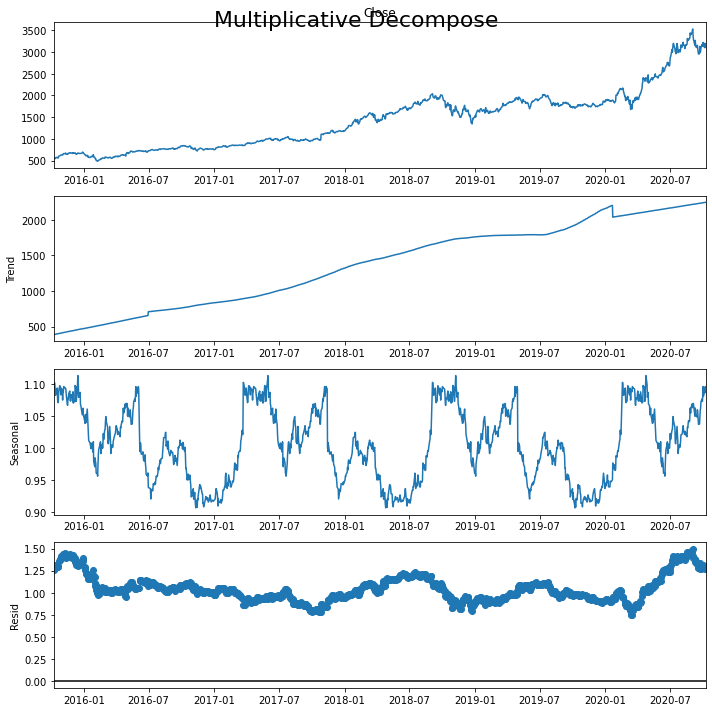

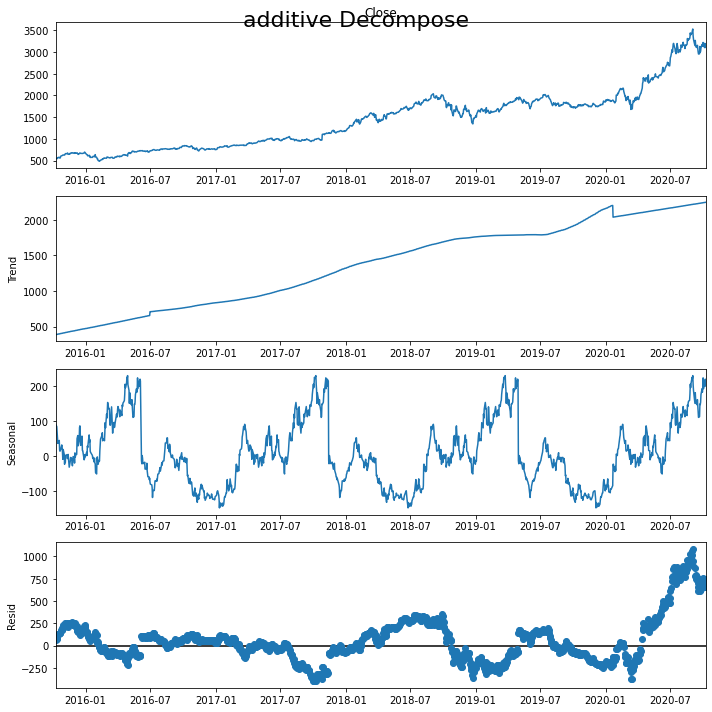

In [98]:
multiplicative = seasonal_decompose(stock_price['Close'], model = 'multiplicative', extrapolate_trend = 'freq', freq=365)
additive = seasonal_decompose(stock_price['Close'], model = 'additive', extrapolate_trend = 'freq', freq=365)

plt.rcParams.update({'figure.figsize': (10,10)})
multiplicative.plot().suptitle('Multiplicative Decompose', fontsize=22)
additive.plot().suptitle('additive Decompose', fontsize=22)
plt.show()

In [99]:
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(stock_price['Close'])

(0.8416666756015275, True)

Stationarity Test

In [122]:
X = stock_price['Open']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.105656
p-value: 0.995265
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


The timeseries is not stationary hence differencing to make it stationary. Difference(q) refers to the no of times you difference the time series to make it stationary.

In [124]:
X = X.diff(1)
X.dropna(inplace = True)

In [125]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.497715
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [128]:
X.shape

(1257,)

In [155]:
train = X[:47]
test = X[47:61]
print(len(train))
print(len(test))

47
14


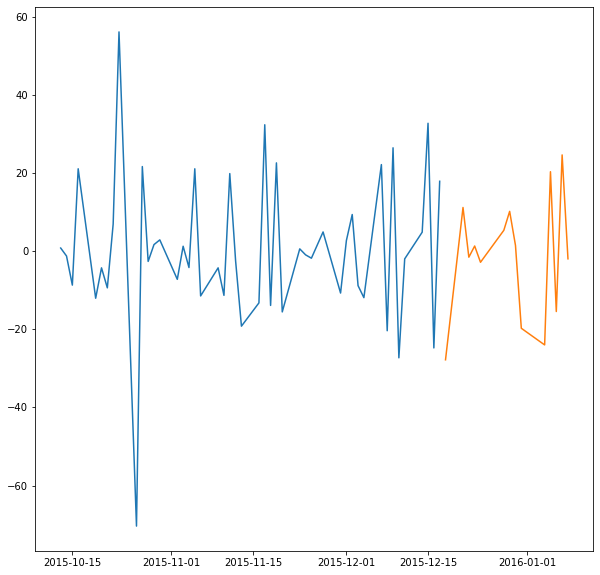

In [156]:
plt.plot(train)
plt.plot(test)

### Auto ARIMA

In [157]:
arima = auto_arima(train)

In [158]:
arima

ARIMA(order=(3, 0, 1), scoring_args={}, with_intercept=False)

In [159]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -184.184
Date:                Fri, 09 Oct 2020   AIC                            378.369
Time:                        20:15:11   BIC                            387.619
Sample:                             0   HQIC                           381.850
                                 - 47                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3816      0.204     -1.874      0.061      -0.781       0.018
ar.L2         -0.2397      0.179     -1.340      0.180      -0.590       0.111
ar.L3         -0.2803      0.222     -1.262      0.207      -0.716       0.155
ma.L1         -0.8813      0.106     -8.332      0.000      -1.089      -0.674
sigma2       139.3259     22.455      6.205      0.000      95.316     183.336
===================================================================================
Ljung-Box (Q):                       36.95   Jarque-Bera (JB):                43.11
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             1.14
Prob(H) (two-sided):                  0.50   Kurtosis:                         7.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [161]:
prediction = pd.DataFrame(arima.predict(n_periods = 14), index = test.index)
prediction.columns = ['Predicted_stock']
prediction

,Predicted_stock
Date,
2015-12-18,-27.522160
2015-12-21,13.145919
2015-12-22,-3.439124
2015-12-23,5.874960
2015-12-24,-5.101876
2015-12-28,1.502517
2015-12-29,-0.997034
2015-12-30,1.450211
2015-12-31,-0.735512


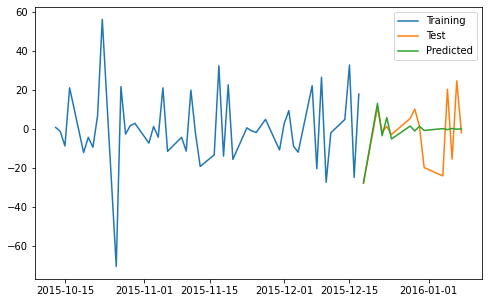

In [162]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend()
plt.show()

In [163]:
from sklearn.metrics import r2_score, mean_squared_error
np.sqrt(mean_squared_error(test, prediction))

13.120105520362154

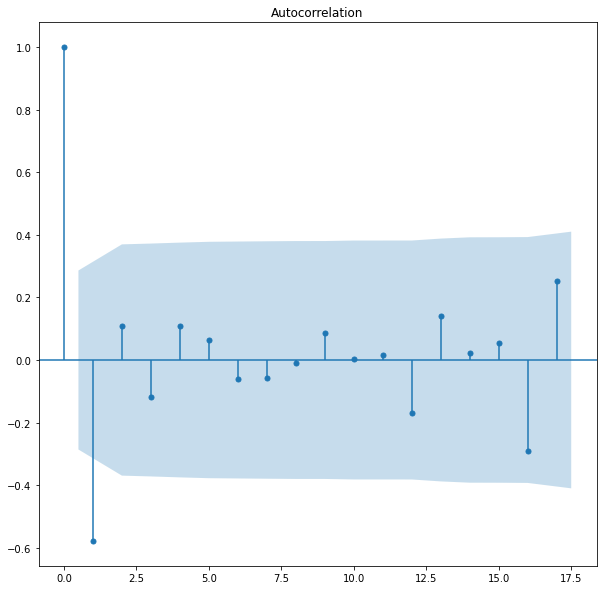

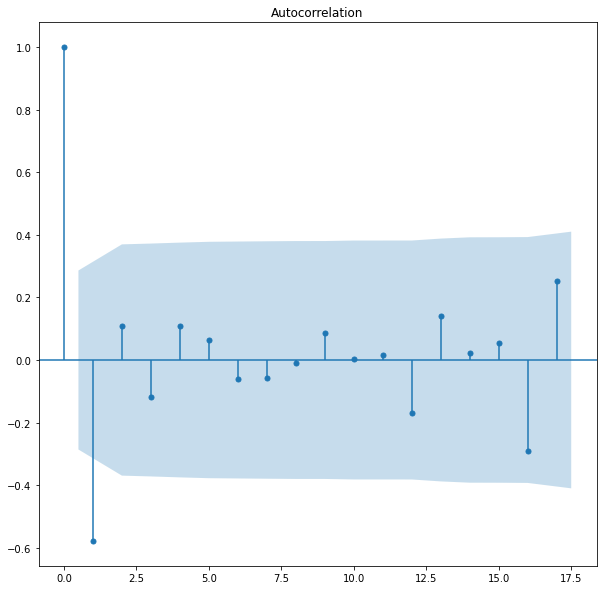

In [164]:
plot_acf(train)

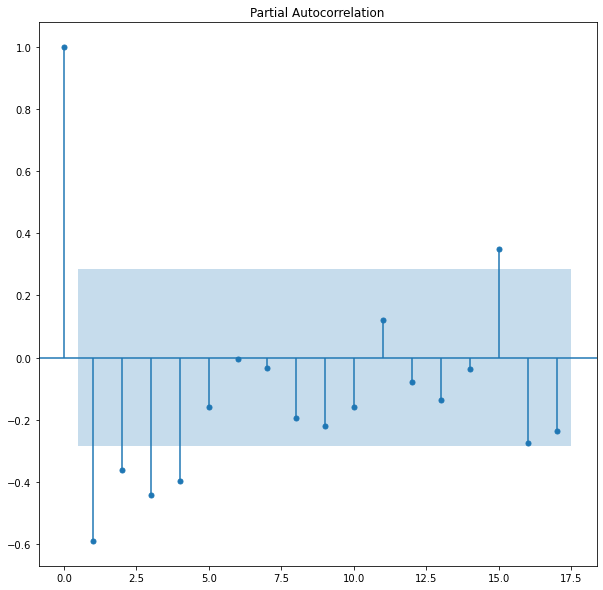

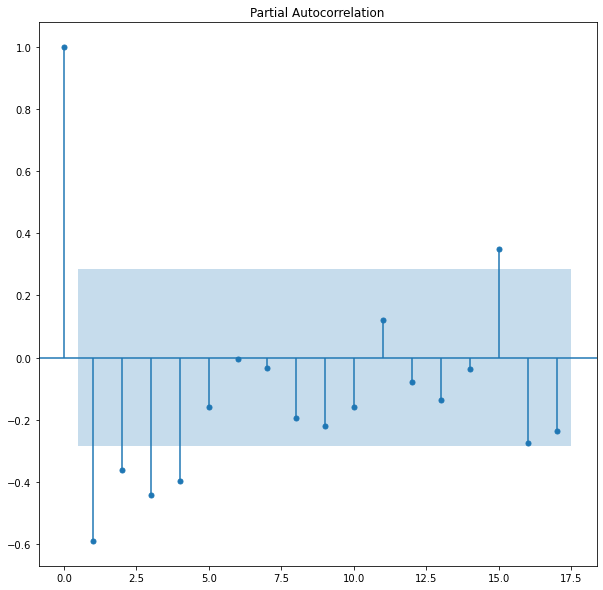

In [165]:
plot_pacf(train)

### Regression Analysis

In [233]:
stock_price.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999666,0.999559,0.999224,0.999224,0.134570
High,0.999666,1.000000,0.999435,0.999618,0.999618,0.143846
Low,0.999559,0.999435,1.000000,0.999632,0.999632,0.121359
Close,0.999224,0.999618,0.999632,1.000000,1.000000,0.132312
Adj Close,0.999224,0.999618,0.999632,1.000000,1.000000,0.132312
Volume,0.134570,0.143846,0.121359,0.132312,0.132312,1.000000


In [234]:
def vif(X):
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [235]:
vif(stock_price1)

,variables,VIF
0,High,8404.857402
1,Low,8680.697929
2,Close,inf
3,Adj Close,inf
4,Volume,4.004917


In [236]:
stock_price1.drop('Adj Close',1,inplace=True)

In [237]:
stock_price1.corr()

,High,Low,Close,Volume
High,1.000000,0.999435,0.999618,0.143846
Low,0.999435,1.000000,0.999632,0.121359
Close,0.999618,0.999632,1.000000,0.132312
Volume,0.143846,0.121359,0.132312,1.000000


In [238]:
vif(stock_price1)

,variables,VIF
0,High,8404.857402
1,Low,8680.697929
2,Close,11843.762103
3,Volume,4.004917


In [239]:
stock_price1.drop('Close',1,inplace=True)

In [240]:
vif(stock_price1)

,variables,VIF
0,High,5629.561778
1,Low,5529.290497
2,Volume,4.004805


In [245]:
stock_price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-10-09,534.479980,541.789978,530.270020,539.799988,539.799988,3537400
2015-10-12,539.960022,550.820007,539.799988,550.190002,550.190002,2776100
2015-10-13,546.260010,553.200012,543.099976,548.900024,548.900024,2938000
2015-10-14,551.340027,552.250000,539.679993,544.830017,544.830017,3582100
2015-10-15,547.750000,563.000000,547.000000,562.440002,562.440002,4937000


In [242]:
lr = LinearRegression(normalize=True)

In [249]:
X = stock_price.drop('Open',1)
y = stock_price['Open']

In [271]:
X_train=X[0:48]
X_test=X[48:61]
y_train=y[0:48]
y_test=y[48:61]

In [272]:
lr.fit(X_train,y_train)
lr_predict=lr.predict(X_test)
np.sqrt(mean_squared_error(lr_predict,y_test))

4.73091451239704

In [273]:
np.mean(lr_predict)

666.0024687498948

In [274]:
np.sqrt(mean_squared_error(lr_predict,y_test))/np.mean(test)

-3.5647331847736723

In [275]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                   Open   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.860e+06
Date:                Sat, 10 Oct 2020   Prob (F-statistic):                        0.00
Time:                        11:49:30   Log-Likelihood:                         -4876.4
No. Observations:                1259   AIC:                                      9761.
Df Residuals:                    1255   BIC:                                      9781.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Random Forest

In [257]:
X1=stock_price_copy.drop('Open',1)
y1=stock_price_copy['Open']

In [276]:
X1_train=X1[0:48]
X1_test=X1[48:61]
y1_train=y1[0:48]
y1_test=y1[48:61]

In [277]:
rf=RandomForestRegressor()
rf.fit(X1_train,y1_train)
rf_pred1=rf.predict(X1_test)

In [278]:
np.sqrt(mean_squared_error(y1_test,rf_pred1))

9.318241848301831

In [279]:
np.sqrt(mean_squared_error(y_test,rf_pred1))/np.mean(y_test)

0.013987331452123044

In [280]:
def mse(y_act, y_pred):
  return np.sqrt(mean_squared_error(y_act,y_pred))

rmse = make_scorer(mse)

In [263]:
params = {  "n_estimators": [10,20,30,100,200,300,350,400],
          "max_features": ["auto", "sqrt", "log2"],
          "min_samples_split" : [2,4,8],
          "bootstrap": [True, False],
          'max_depth':[1,3,5,7,9]}
best_rf=GridSearchCV(rf,param_grid=params,n_jobs=-1,cv=3)

In [264]:
%%time
best_rf.fit(X1_train,y1_train)

CPU times: user 15.7 s, sys: 657 ms, total: 16.4 s
Wall time: 2min 28s


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 3, 5, 7, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 30, 100, 200, 300, 350, 400]})

In [265]:
best_rf.best_params_

{'bootstrap': False,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 20}

In [266]:
best_rf_predict=best_rf.predict(X1_test)
np.sqrt(mean_squared_error(y1_test,best_rf_predict))

8.64254229211937

In [267]:
np.mean(y1_test)

669.8741658333333

In [268]:
error=np.sqrt(mean_squared_error(y1_test,best_rf_predict))/np.mean(y1_test)
error

0.01290173995793362

### SVM (Linear Model)

In [270]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
svc=SVR(kernel='linear')

In [282]:
# Scaling data to converge faster
X_scaled=sc.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled,index=X.index)
X2_train=X_scaled[0:48]
X2_test=X_scaled[48:61]

In [283]:
svc.fit(X2_train,y1_train)

SVR(kernel='linear')

In [284]:
svc_pred=svc.predict(X2_test)
rmse_svr=np.sqrt(mean_squared_error(y1_test,svc_pred))
rmse_svr

22.71794959973822

In [285]:
y_new=stock_price_copy['Open'].values.reshape(-1,1)

In [290]:
#Sacling both independent and dependent variable
X_scaled=sc.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled,index=X.index)
y_scaled=sc.fit_transform(y_new)
y_scaled=pd.DataFrame(y_scaled,index=y.index)
X2_train=X_scaled[0:48]
X2_test=X_scaled[48:61]
y2_train=y_scaled[0:48]
y2_test=y_scaled[48:61]

In [291]:
svc.fit(X2_train,y2_train)
svc_pred_new=svc.predict(X2_test)
rmse_svr_new=np.sqrt(mean_squared_error(y2_test,svc_pred_new))
rmse_svr_new

0.0828864568186113

In [292]:
#Reverse scaling
y_pred_svc = sc.inverse_transform(svc_pred_new)
y_pred_svc
rmse_svr_new_final=np.sqrt(mean_squared_error(y1_test,y_pred_svc))
rmse_svr_new_final

56.058721452676764

In [293]:
rmse_svr_new_final/np.mean(y1_test)

0.08414805394686425

Reverse scaling didn't work in this case

In [294]:
#Polynomial Kernal
svc2=SVR(kernel='poly')
svc2.fit(X2_train,y2_train)
svc_poly=svc2.predict(X2_test)
rmse_svr_poly=np.sqrt(mean_squared_error(y2_test,svc_poly))
print(rmse_svr_poly)
y_pred_poly = sc.inverse_transform(svc_poly)
print(y_pred_poly)
rmse_svr_poly_final=np.sqrt(mean_squared_error(y1_test,y_pred_poly))
print(rmse_svr_poly_final)
rmse_svr_poly_final/np.mean(y1_test)

0.08180115196053882
[612.95533791 615.56187097 612.20741892 612.11098053 612.04561516
 612.83843071 612.94119973 615.57342518 613.98470865 613.33136889
 618.24461738 612.09010903 611.21527202]
55.324695592902515


0.08304622989440492

The polynomial kernal is not effective in this case. 
The best model is random forest with grid search parameter

Reference : Analytics Vidya - Time series forecasting